# The functionality for generating new features


The `feature-encoders` library includes a few feature generators:

- `TrendFeatures`: Generates time trend features.
- `DatetimeFeatures`: Generates date and time features (such as the month of the year or the hour of the week).
- `CyclicalFeatures`: Creates cyclical (seasonal) features as Fourier terms (similarly to the way the [Prophet library](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) generates seasonality features).


All feature generators generate pandas `DataFrame`s, and they all have two common parameters:

```yaml
remainder : str, {'drop', 'passthrough'}, default='passthrough'
    By specifying `remainder='passthrough'`, all the remaining columns of the
    input dataset will be automatically passed through (concatenated with the
    output of the transformer).
replace : bool, default=False
    Specifies whether replacing an existing column with the same name is allowed
    (when `remainder=passthrough`).
```


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
from feature_encoders.generate import CyclicalFeatures, DatetimeFeatures, TrendFeatures

## Load demo data

In [3]:
data = pd.read_csv('data/data.csv', parse_dates=[0], index_col=0)
data = data[~data['consumption_outlier']]

## Create time trend features 

The `ds` argument corresponds to the name of the input dataframe's column that contains datetime information. If `None`, it is assumed that the datetime information is provided by the input dataframe's index.

In [4]:
enc = TrendFeatures(ds=None, name='growth', remainder='drop')
features = enc.fit_transform(data)

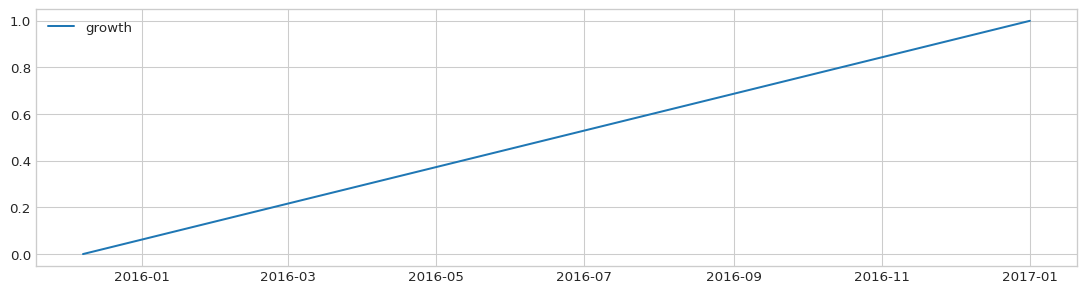

In [5]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.plot(features['growth'], label='growth')
    ax.legend(loc='upper left')

## Add date and time features

The `subset` argument corresponds to the names of the features to generate. If `None`, all features will be produced: 'month', 'week', 'dayofyear', 'dayofweek', 'hour', 'hourofweek'. The last 2 features are generated only if the timestep of the input's `feature` (or index if `feature` is None) is smaller than `pandas.Timedelta(days=1)`.

In [6]:
enc = DatetimeFeatures(ds=None, subset=None, remainder='drop')
features = enc.fit_transform(data)
features.columns

Index(['month', 'week', 'dayofyear', 'dayofweek', 'hour', 'hourofweek'], dtype='object')

In [7]:
enc = DatetimeFeatures(ds=None, remainder='drop', subset=['month', 'hourofweek'])
features = enc.fit_transform(data)
features.columns

Index(['month', 'hourofweek'], dtype='object')

## Encode cyclical (seasonal) features

The encoder is parameterized by `period` (number of days in one period) and `fourier_order` (number of Fourier components to use).

It can provide default values for `period` and `fourier_order` if `seasonality` is one of `daily`, `weekly` or `yearly`.

In [8]:
daily_consumption = data[['consumption']].resample('D').sum()

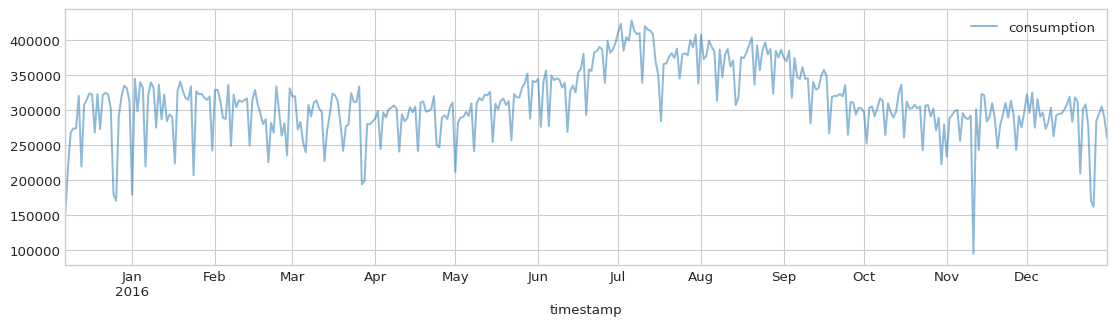

In [9]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    daily_consumption.plot(ax=ax, alpha=0.5)

The number of seasonality features is always twice the `fourier_order`.

In [10]:
enc = CyclicalFeatures(ds=None, seasonality='yearly', fourier_order=3, remainder='drop')
features = enc.fit_transform(daily_consumption)
features.columns

Index(['yearly_delim_0', 'yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3',
       'yearly_delim_4', 'yearly_delim_5'],
      dtype='object')

Now let’s plot the new features:

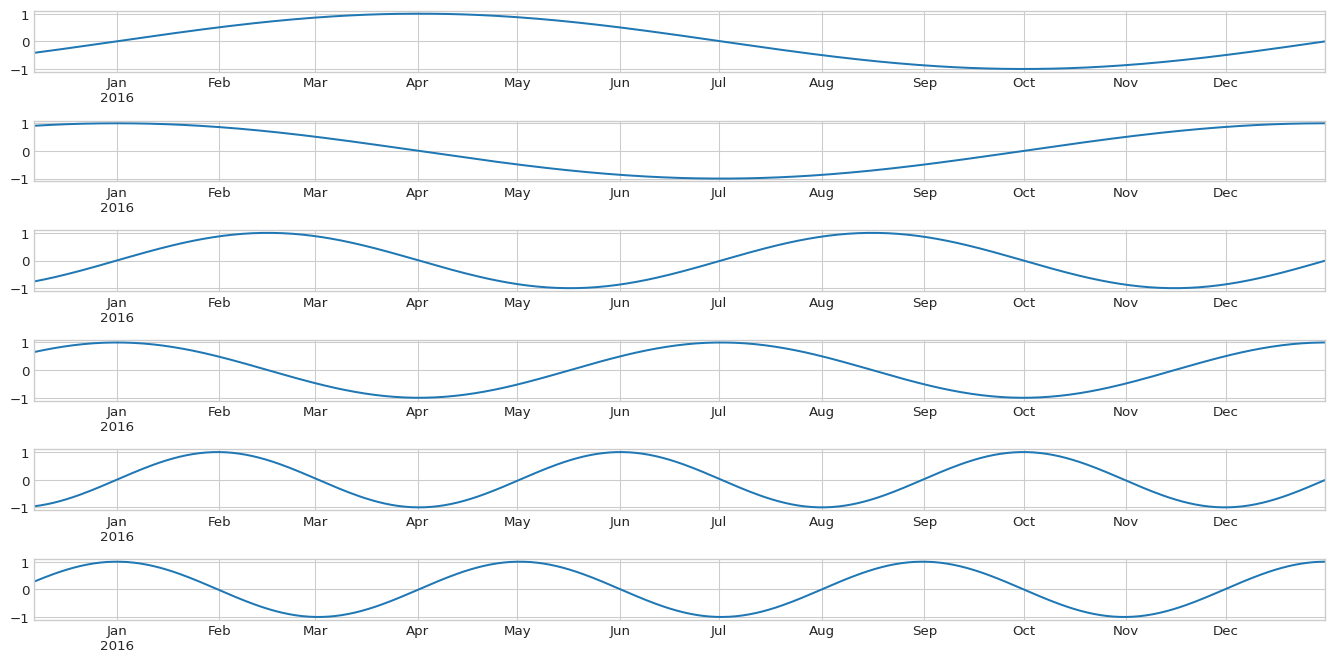

In [11]:
with plt.style.context('seaborn-whitegrid'):    
    fig, axs = plt.subplots(2*enc.fourier_order, figsize=(14, 7), dpi=96)
    
    for i, col in enumerate(features.columns):
        features[col].plot(ax=axs[i])
        axs[i].set_xlabel(None)
    
fig.tight_layout()

Let's also see how well this transformation works:

In [12]:
regr = LinearRegression(fit_intercept=True).fit(features, daily_consumption)
pred = regr.predict(features)

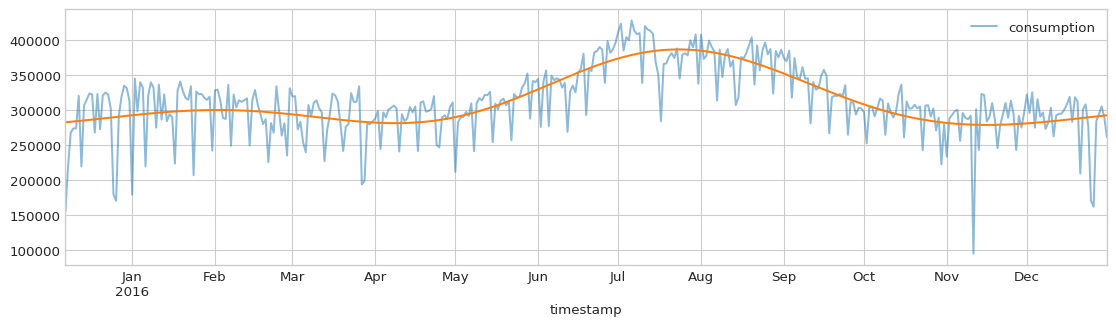

In [13]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    daily_consumption.plot(ax=ax, alpha=0.5)
    pd.Series(pred.squeeze(), index=daily_consumption.index).plot(ax=ax)

----------------